In [1]:
# Pandas for DataFrames
import pandas as pd
# NumPy for numerical computing
import numpy as np
# Seaborn for easier visualization
import seaborn as sns
#sns.set_style('darkgrid')
# Matplotlib for visualization
import matplotlib.pyplot as plt
# display plots in the notebook
%matplotlib inline

#For the linear regression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier

In [2]:
def load_train_test_data():
    category_columns=['thal',
                      'slope_of_peak_exercise_st_segment',  
                      'chest_pain_type',
                      'num_major_vessels', 
                      'exercise_induced_angina']
    
    features_to_drop = ['fasting_blood_sugar_gt_120_mg_per_dl', 
                        'sex', 
                        'age', 
                        'resting_ekg_results',
                        'resting_blood_pressure', 
                        'serum_cholesterol_mg_per_dl']
    
    df_train_values = pd.read_csv('heart_train_values.csv')
    df_train_labels = pd.read_csv('heart_train_labels.csv')
    #Merge TRAIN data so that we have
    df_train = pd.merge(df_train_values, df_train_labels, on='patient_id')
    
    df_train_expanded = pd.get_dummies(df_train, columns=category_columns)
    df_train_expanded.drop(columns=features_to_drop, axis=1, inplace=True)
    
    #TEST data comes with patient id and target variable 
    df_test_values = pd.read_csv('heart_test.csv')
    
    df_test_expanded = pd.get_dummies(df_test_values, columns=category_columns)
    df_test_expanded.drop(columns=features_to_drop, axis=1, inplace=True)
    return df_train_expanded, df_test_expanded

In [11]:
def print_scores(X_test, y_test, y_pred, predict_proba, show_graph=True):
    print('Accuracy Score : ', metrics.accuracy_score(y_test, y_pred))
    print('Sample Logloss : ', np.round(metrics.log_loss(y_test, predict_proba),4))
    print('MAE            : ', metrics.mean_absolute_error(y_test, y_pred))
    print('MSE            : ', metrics.mean_squared_error(y_test, y_pred))

    print('\n-------------------- C O N F U S I O N   M A T R I X --------------------')
    print(metrics.confusion_matrix(y_test, y_pred)) 

    print('\n-------------------- C L A S S I F I C A T I O N   R E P O R T --------------------')
    print(metrics.classification_report(y_test, y_pred)) 
    
    if (show_graph):   
        df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
        df.head(50).plot(kind='bar',figsize=(16,8))
        plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
        plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')

In [4]:
df_train_data, df_test_data = load_train_test_data()

In [5]:
df_train_data.columns

Index(['patient_id', 'oldpeak_eq_st_depression', 'max_heart_rate_achieved',
       'heart_disease_present', 'thal_fixed_defect', 'thal_normal',
       'thal_reversible_defect', 'slope_of_peak_exercise_st_segment_1',
       'slope_of_peak_exercise_st_segment_2',
       'slope_of_peak_exercise_st_segment_3', 'chest_pain_type_1',
       'chest_pain_type_2', 'chest_pain_type_3', 'chest_pain_type_4',
       'num_major_vessels_0', 'num_major_vessels_1', 'num_major_vessels_2',
       'num_major_vessels_3', 'exercise_induced_angina_0',
       'exercise_induced_angina_1'],
      dtype='object')

In [6]:
# Separate input feature(s) and target variable
X = df_train_data.drop(['patient_id','heart_disease_present'], axis=1)
y = df_train_data.heart_disease_present

In [7]:
# Run a logistic raegression
# Initialize model instance
lm = LogisticRegression()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

# Fit model
lm.fit(X_train, y_train)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

Accuracy Score :  0.8333333333333334
Sample Logloss :  0.5251
MAE            :  0.16666666666666666
MSE            :  0.16666666666666666

-------------------- C O N F U S I O N   M A T R I X --------------------
[[13  1]
 [ 5 17]]

-------------------- C L A S S I F I C A T I O N   R E P O R T --------------------
              precision    recall  f1-score   support

           0       0.72      0.93      0.81        14
           1       0.94      0.77      0.85        22

   micro avg       0.83      0.83      0.83        36
   macro avg       0.83      0.85      0.83        36
weighted avg       0.86      0.83      0.84        36



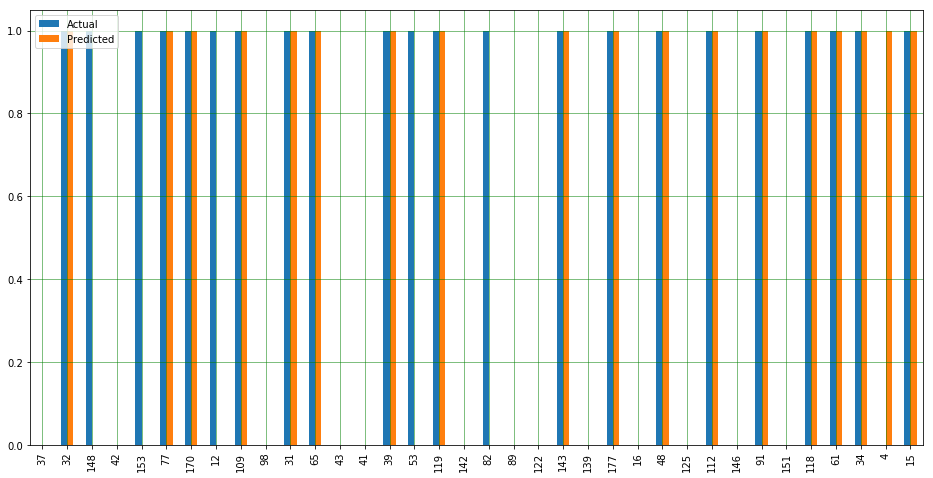

In [9]:
y_pred = lm.predict(X_test)

print_scores (X_test, y_test, y_pred, lm.predict_proba(X_test))

In [198]:
y_pred

array([0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1])

In [12]:
def get_random_forest_model(X, y, test_size=0.2, show_graph = True) :
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=101)
    
    param_grid = {'max_depth': range(3,7),
                  'n_estimators': (10, 50, 100, 300, 500, 1000),
                 }
    
    # Perform Grid-Search
    gsc = GridSearchCV(estimator=RandomForestClassifier(),
                       param_grid=param_grid,
                       cv=5, 
                       scoring='neg_mean_squared_error', 
                       verbose=3, 
                       n_jobs=-1)
    
    grid = gsc.fit(X_train, y_train)
    # print best parameter after tuning 
    print(grid.best_params_)
    
    # print how our model looks after hyper-parameter tuning 
    print(grid.best_estimator_) 
    
    #PREDICT TEST DATA
    y_pred = grid.predict(X_test)
    
    print_scores(X_test, y_test, y_pred, grid.predict_proba(X_test), show_graph=show_graph)
        
    return grid

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   22.7s finished
/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'max_depth': 3, 'n_estimators': 500}
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
Accuracy Score :  0.8611111111111112
Sample Logloss :  0.4859
MAE            :  0.1388888888888889
MSE            :  0.1388888888888889

-------------------- C O N F U S I O N   M A T R I X --------------------
[[13  1]
 [ 4 18]]

-------------------- C L A S S I F I C A T I O N   R E P O R T --------------------
              precision    recall  f1-score   support

           0       0.76      0.93      0.84        14
           1       0.95      0.82      0.88        22

   micro avg       0.86      0.86      0.86        36
   macr

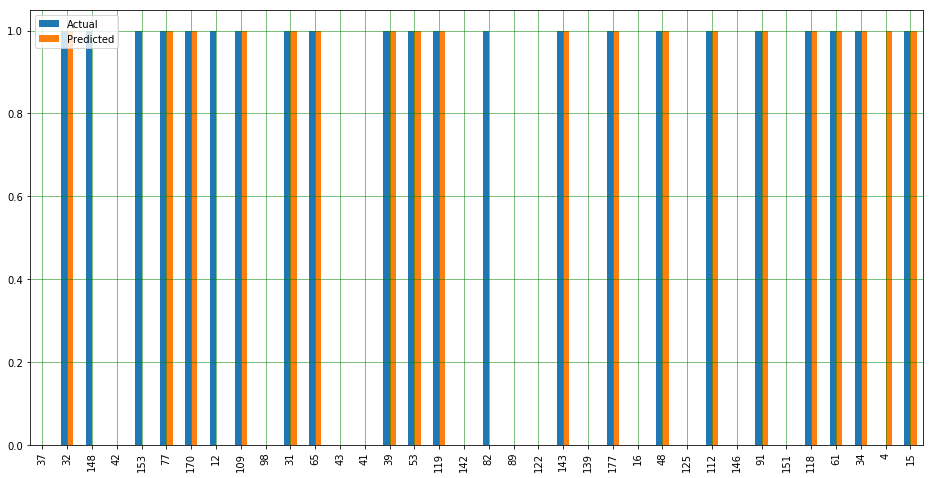

In [13]:
rfm = get_random_forest_model (X,y)

In [14]:
test_data = df_test_data.drop(columns=['patient_id'])
rfm.predict(test_data)

array([0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0,
       0, 0])

In [16]:
predicted_proba = rfm.predict_proba(test_data)
predicted_proba

array([[0.64043828, 0.35956172],
       [0.80153016, 0.19846984],
       [0.16587727, 0.83412273],
       [0.82881711, 0.17118289],
       [0.26458597, 0.73541403],
       [0.90275248, 0.09724752],
       [0.57416929, 0.42583071],
       [0.34092383, 0.65907617],
       [0.83095157, 0.16904843],
       [0.9161787 , 0.0838213 ],
       [0.66759363, 0.33240637],
       [0.49170974, 0.50829026],
       [0.68498063, 0.31501937],
       [0.1796857 , 0.8203143 ],
       [0.84050748, 0.15949252],
       [0.92176851, 0.07823149],
       [0.92774911, 0.07225089],
       [0.77092811, 0.22907189],
       [0.35695069, 0.64304931],
       [0.92855872, 0.07144128],
       [0.08394769, 0.91605231],
       [0.80558409, 0.19441591],
       [0.79247825, 0.20752175],
       [0.86908779, 0.13091221],
       [0.547601  , 0.452399  ],
       [0.20992023, 0.79007977],
       [0.64233566, 0.35766434],
       [0.74671519, 0.25328481],
       [0.41109137, 0.58890863],
       [0.90170537, 0.09829463],
       [0.

In [17]:
predicted_proba[:, 1]

array([0.35956172, 0.19846984, 0.83412273, 0.17118289, 0.73541403,
       0.09724752, 0.42583071, 0.65907617, 0.16904843, 0.0838213 ,
       0.33240637, 0.50829026, 0.31501937, 0.8203143 , 0.15949252,
       0.07823149, 0.07225089, 0.22907189, 0.64304931, 0.07144128,
       0.91605231, 0.19441591, 0.20752175, 0.13091221, 0.452399  ,
       0.79007977, 0.35766434, 0.25328481, 0.58890863, 0.09829463,
       0.84654574, 0.4372335 , 0.50828666, 0.3846948 , 0.16961829,
       0.16908495, 0.35979945, 0.26702681, 0.28630089, 0.09536205,
       0.93207602, 0.24003376, 0.78996496, 0.1236068 , 0.82000309,
       0.09727466, 0.16961829, 0.3359169 , 0.11364629, 0.54535348,
       0.59490126, 0.07686967, 0.93392846, 0.09173315, 0.38016186,
       0.08830057, 0.7514018 , 0.30471126, 0.24125564, 0.62715518,
       0.07832966, 0.83817161, 0.16904843, 0.74898456, 0.1057691 ,
       0.6069076 , 0.59132992, 0.553575  , 0.75591267, 0.60349276,
       0.2078038 , 0.91259374, 0.86248318, 0.94990141, 0.76633

In [18]:
patient_ids = df_test_data['patient_id']
probabilities = predicted_proba[:, 1]

predicted_data = pd.DataFrame({'patient_id': patient_ids, 
                               'heart_disease_present': probabilities})
predicted_data.to_csv("predictions.csv", index=False)

In [226]:
predicted_data

,patient_id,heart_disease_present
0,olalu7,0.380400
1,z9n6mx,0.217130
2,5k4413,0.837701
3,mrg7q5,0.164491
4,uki4do,0.724066
5,kev1sk,0.093861
6,9n6let,0.432657
7,jxmtyg,0.682258
8,51s2ff,0.182545
9,wi9mcs,0.086669
